In [13]:
from space.planets import venus
from orbit.pointing import simulation
from orbit.geometry import getTiming
from orbit.envision import loadSV

""" System Packages """
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime as dt
import os

In [14]:
sim_folder = os.path.join(r"C:\Users",
                          r"ishuwa.sikaneta",
                          r"OneDrive - ESA",
                          r"Documents",
                          r"ESTEC",
                          r"Envision",
                          r"PointingSimulations")

### Load ESOC-supplied orbit file

In [15]:
sv = loadSV()

# Simulate Pointing Errors

The following class simulates pointing errors for an Envision-type SAR

In [16]:
eSim = simulation(planet = venus(),
                  e_ang = 14.28, # The effective angle of the beam relative to spacecraft coordinate frame
                  azAxis = 5.5,  # The length of the refelector in the azimuth direction. Leads to 0.99 degrees
                  elAxis = 0.6125,  # The length of the reflector in the elevation direction. Leads to 8.9 degrees
                  carrier = 3.15e9)

### Select a subset of state vectors

Select a range of state vectors to use for error simulation

In [17]:
selection_range = [270, 480, 2]
mysvs = eSim.state(sv.measurementData, selection_range)
 
times = [(sv.measurementTime[k] - sv.measurementTime[0])/np.timedelta64(1, 's') 
         for k in range(*selection_range)]

### Define Covariances

Define the set of input covariance matrices for the simulation. These have been determined from the pointing justification document (ESA) and the JPL-provided pointing spreadsheet.

In [22]:
""" Define the covariances """  
covariances = {
    "spacecraft": {
        "description": "Errors in the orientation of the spacecraft.",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((0*np.diag([8.2e-3, 0.93e-3, 0.93e-3])/2)**2).tolist()
        },
    "instrument": {
        "description": """Errors in the pointing of the antenna. From JPL
                          spreadsheet cells 'SAR APE Pointing Budget'!D34:36
                          These are Allocation values and do not include a 20% 
                          margin.""",
        "referenceVariables": "AzimuthElevationTilt",
        "units": "radians",
        "R": ((0*np.diag([0.65e-3, 4.50e-3, 0.52e-3])/2)**2).tolist()
        },
    "orbitVelocity": {
        "description": "Errors in the orbit velocity vector",
        "referenceVariables": "VxVyVz",
        "units": "m/s",
        "R": ((0*np.diag([0.4, 0.4, 0.4])/2)**2).tolist()
        },
    "orbitAlongTrack": {
        "description": "Error in the orbit time (error in orbit angle)",
        "referenceVariables": "t",
        "units": "s",
        "R": (4.3/2)**2
        },
    "orbitAcrossTrack": {
        "description": "Error in the orbit across track position (orbit tube)",
        "referenceVariables": "dX",
        "units": "m",
        "R": (0*np.diag([(600/2)**2, (850/2)**2])).tolist()
        }
    }


### Test the simulation of errors

Test right looking configuration with an off-nadir angle of -18.7 and left looking with an off-nadir of 18.7

Norm of u: 1.000000
u*e1: 0.000000
u*e2: 0.947133, v: 0.947210
uP*VP: -0.000000
Roll: 4.4186, Pitch: 0.0010, Yaw: 0.0123
0.002409398498629671
Percent of Doppler centroids in violation: 63.0783


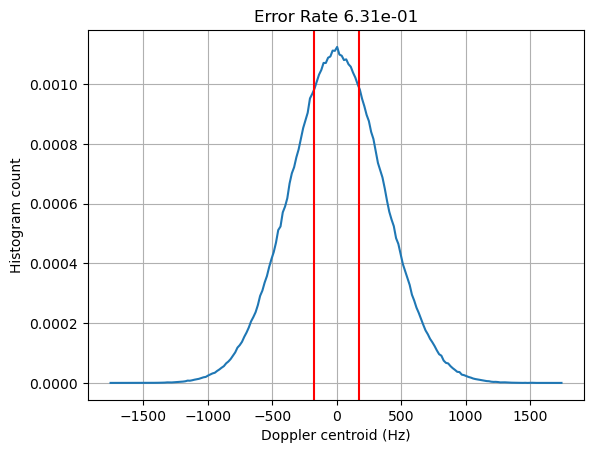

Percent of Swaths in violation: 0.0000


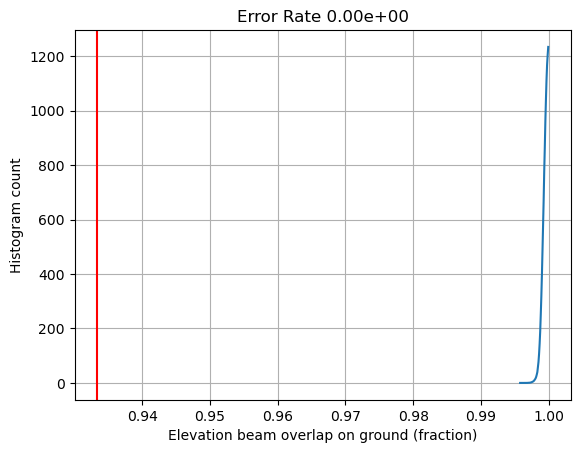

{
  "given": {
    "off_nadir": 18.7,
    "azAxis": 5.5,
    "elAxis": 0.6125,
    "carrier": 3150000000.0,
    "covariances": {
      "spacecraft": {
        "description": "Errors in the orientation of the spacecraft.",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": [
          [
            0.0,
            0.0,
            0.0
          ],
          [
            0.0,
            0.0,
            0.0
          ],
          [
            0.0,
            0.0,
            0.0
          ]
        ]
      },
      "instrument": {
        "description": "Errors in the pointing of the antenna. From JPL\n                          spreadsheet cells 'SAR APE Pointing Budget'!D34:36\n                          These are Allocation values and do not include a 20% \n                          margin.",
        "referenceVariables": "AzimuthElevationTilt",
        "units": "radians",
        "R": [
          [
            0.0,
            0.0,
            0

In [24]:
off_nadir = 18.7
res = eSim.simulateError(mysvs[0], 
                         off_nadir, 
                         covariances,
                         loglevel=3)

In [38]:
aeu_cv = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[3:6,3:6]
sgm = np.sqrt(np.diag(aeu_cv))
nrm = np.outer(sgm, sgm)
print(aeu_cv)
print(20*"=")
print(sgm)
print(nrm)
print(20*"=")
print(2*sgm*1e3)
print(2*np.degrees(sgm))
print(20*"=")
print(aeu_cv/nrm)

[[ 5.76378938e-06  1.25321961e-09 -9.46134654e-08]
 [ 1.25321961e-09  2.79354794e-13 -2.05719666e-11]
 [-9.46134654e-08 -2.05719666e-11  1.55309420e-09]]
[2.40078932e-03 5.28540248e-07 3.94093162e-05]
[[5.76378938e-06 1.26891379e-09 9.46134655e-08]
 [1.26891379e-09 2.79354794e-13 2.08294098e-11]
 [9.46134655e-08 2.08294098e-11 1.55309420e-09]]
[4.80157865e+00 1.05708050e-03 7.88186323e-02]
[2.75110191e-01 6.05662511e-05 4.51597498e-03]
[[ 1.         0.9876318 -1.       ]
 [ 0.9876318  1.        -0.9876404]
 [-1.        -0.9876404  1.       ]]


### Simulate errors over time

The following function allows simulation of pointing errors over different parts of the orbit. The input `np.array(N,6)` supplies N state vectors over the orbit, and the simulation of pointing errors is performed over these points.

In [26]:
def errorsOverTime(mysvs, off_nadir, covariances):
    """
    Simulate pointing errors over time

    Simulate pointing errors over different orbit positions - which
    correspond to different points in time.

    Parameters
    ----------
    mysvs : `np.ndarray(6,N)`
        Input array of state vectors
    off_nadir : float
        The off-nadir angle for the desired beam elevation direction
    covariances : dict
        A dictionary (json snippet) containing covariances to use in
        the simultation

    Returns
    -------
    dict
        A dictionary (json snippet) containing the computed zero-Doppler
        parameters and simulation results from the pointing error analysis.
    """
    result = []
    for k in tqdm(range(len(mysvs))):
        dd = eSim.simulateError(mysvs[k], 
                                off_nadir, 
                                covariances)
        result.append(dd)
    return result

### Compute errors for 20 degree incidence

Compute the errors in swath beam overlap and Doppler centroid for the 20 degree incidence angle case. This should be the worst case for roll error.

According to the plot of off-nadir versus incidence angle, the 20 degree incidence angle corresponds to a 18.7 degree off-nadir angle.

In [ ]:
res18p7 = errorsOverTime(mysvs, 18.7, covariances)

In [ ]:
filename = r"incidence20-%s.json" % dt.now().strftime("%Y-%m-%dT%H%M%S")
with open(os.path.join(sim_folder, filename), "w") as f:
    f.write(json.dumps(res18p7, indent=2))

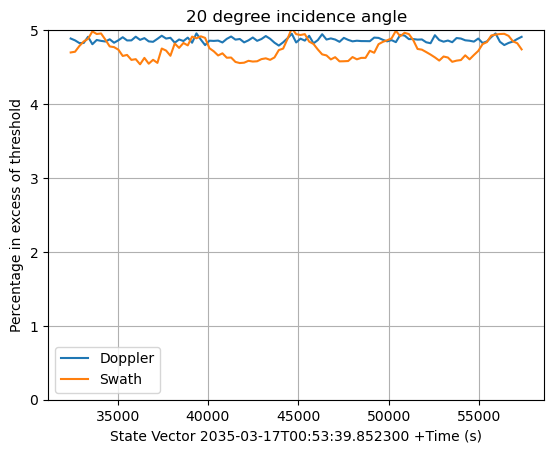

4.7392038095238105
0.017847063223582767
0.0011605319854875278
4.868343809523809


In [ ]:
dErrorRate = np.array([r["ErrorRate"]["Doppler"] for r in res18p7])
sErrorRate = np.array([r["ErrorRate"]["Swath"] for r in res18p7])
plt.figure()
plt.plot(times, dErrorRate)
plt.plot(times, sErrorRate)
plt.ylim(0,5)
plt.title("20 degree incidence angle")
plt.ylabel("Percentage in excess of threshold")
plt.xlabel("State Vector %s +Time (s)" % np.datetime_as_string(sv.measurementTime[0]))
plt.legend(["Doppler", "Swath"])
plt.grid()
plt.show()
print(np.mean(sErrorRate))
print(np.var(sErrorRate))
print(np.var(dErrorRate))
print(np.mean(dErrorRate))

In [28]:
#%% Run the simulation over a range of different pitch and yaw variances
parray = np.arange(0.3, 0.6, 0.05)*1.0e-3
yarray = np.arange(0.3, 1.4, 0.05)*1.0e-3

res5p1 = []
res4p1 = []
for p in parray:
    for y in yarray:
        print("Pitch: %0.2e, Yaw: %0.2e" % (p,y))
        covariances["spacecraft"]["R"] = (np.diag([4.1e-3, p, y])**2).tolist()
        res4p1.append(eSim.simulateError(mysvs[0], off_nadir, covariances))
        covariances["spacecraft"]["R"] = (np.diag([5.1e-3, p, y])**2).tolist()
        res5p1.append(eSim.simulateError(mysvs[0], off_nadir, covariances))

Pitch: 3.00e-04, Yaw: 3.00e-04
Pitch: 3.00e-04, Yaw: 3.50e-04
Pitch: 3.00e-04, Yaw: 4.00e-04
Pitch: 3.00e-04, Yaw: 4.50e-04
Pitch: 3.00e-04, Yaw: 5.00e-04
Pitch: 3.00e-04, Yaw: 5.50e-04
Pitch: 3.00e-04, Yaw: 6.00e-04
Pitch: 3.00e-04, Yaw: 6.50e-04
Pitch: 3.00e-04, Yaw: 7.00e-04
Pitch: 3.00e-04, Yaw: 7.50e-04
Pitch: 3.00e-04, Yaw: 8.00e-04
Pitch: 3.00e-04, Yaw: 8.50e-04
Pitch: 3.00e-04, Yaw: 9.00e-04
Pitch: 3.00e-04, Yaw: 9.50e-04
Pitch: 3.00e-04, Yaw: 1.00e-03
Pitch: 3.00e-04, Yaw: 1.05e-03
Pitch: 3.00e-04, Yaw: 1.10e-03
Pitch: 3.00e-04, Yaw: 1.15e-03
Pitch: 3.00e-04, Yaw: 1.20e-03
Pitch: 3.00e-04, Yaw: 1.25e-03
Pitch: 3.00e-04, Yaw: 1.30e-03
Pitch: 3.00e-04, Yaw: 1.35e-03
Pitch: 3.50e-04, Yaw: 3.00e-04
Pitch: 3.50e-04, Yaw: 3.50e-04
Pitch: 3.50e-04, Yaw: 4.00e-04
Pitch: 3.50e-04, Yaw: 4.50e-04
Pitch: 3.50e-04, Yaw: 5.00e-04
Pitch: 3.50e-04, Yaw: 5.50e-04
Pitch: 3.50e-04, Yaw: 6.00e-04
Pitch: 3.50e-04, Yaw: 6.50e-04
Pitch: 3.50e-04, Yaw: 7.00e-04
Pitch: 3.50e-04, Yaw: 7.50e-04
Pitch: 3

In [29]:
""" Save data to file """
filename = r"pitchYawRoll5p5-%s.json" % dt.now().strftime("%Y-%m-%dT%H%M%S")
with open(os.path.join(sim_folder, filename), "w") as f:
    f.write(json.dumps(res5p5, indent=2))
    
filename = r"pitchYawRoll4p5-%s.json" % dt.now().strftime("%Y-%m-%dT%H%M%S")
with open(os.path.join(sim_folder, filename), "w") as f:
    f.write(json.dumps(res4p5, indent=2))

In [30]:
#%% Read the Doppler error rate from the result of the previous cell
dprate = np.array([r["ErrorRate"]["Doppler"]
            for r in res4p5]).reshape((len(parray), len(yarray)))

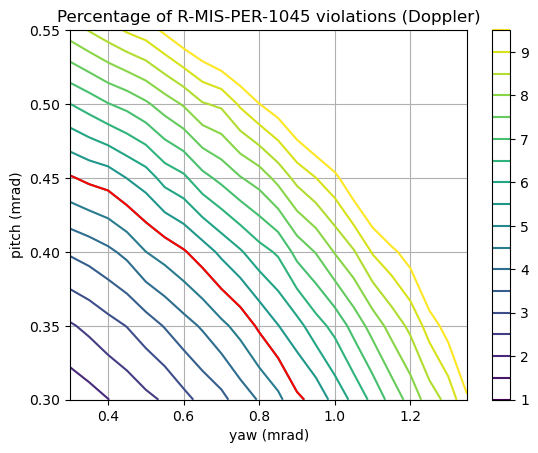

In [31]:
#%% Make a contour plot of the percentage of Doppler errors
plt.figure()
plt.contour(yarray*1e3, parray*1e3, dprate, np.arange(1,10,0.5), origin='lower')
plt.xlabel("yaw (mrad)")
plt.ylabel("pitch (mrad)")
plt.colorbar()
plt.grid()
plt.contour(yarray*1e3,
            parray*1e3,
            dprate,
            np.array([5]),
            origin='lower',
            colors = ['red'])
plt.title("Percentage of R-MIS-PER-1045 violations (Doppler)")
plt.show()

In [16]:
#%% Read the Doppler error rate from the result of the previous cell
dprate = np.array([r["ErrorRate"]["Doppler"]
            for r in res5p5]).reshape((len(parray), len(yarray)))

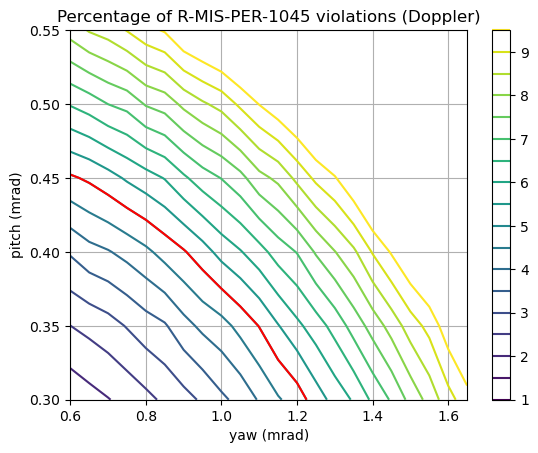

In [17]:
#%% Make a contour plot of the percentage of Doppler errors
plt.figure()
plt.contour(yarray*1e3, parray*1e3, dprate, np.arange(1,10,0.5), origin='lower')
plt.xlabel("yaw (mrad)")
plt.ylabel("pitch (mrad)")
plt.colorbar()
plt.grid()
plt.contour(yarray*1e3,
            parray*1e3,
            dprate,
            np.array([5]),
            origin='lower',
            colors = ['red'])
plt.title("Percentage of R-MIS-PER-1045 violations (Doppler)")
plt.show()